# Face Mask Detection 

Firstly, we have **"data"** folder containing two subfolders **"with_mask"** and **"without_mask"**. Then split **"data"** folder to separate **"train"**, **"test"**, **"validation"** folder.

## Split Data Folders to Tran-Test-Validation folders

In [1]:
pip install split-folders


Note: you may need to restart the kernel to use updated packages.


In [6]:
import splitfolders
splitfolders.ratio('data', output="output", seed=1337, ratio=(.7, 0.2,0.1)) 

Copying files: 4095 files [00:03, 1186.78 files/s]


## Read data from "train", "test", "validation" folders.

In [6]:
# Path of Dataset
PATH = 'E:\\Jupyter_Notebook_Projects\\All_Projects\\Experiments\\output'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 3273 files belonging to 2 classes.


In [7]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 819 files belonging to 2 classes.


In [8]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 410 files belonging to 2 classes.


In [54]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


## Visualize the data

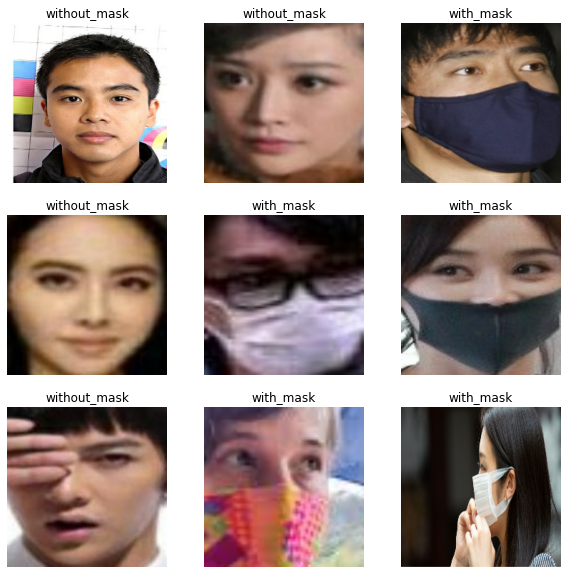

In [392]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Autotuning data fetch

In [393]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Data Augmentation

In [481]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

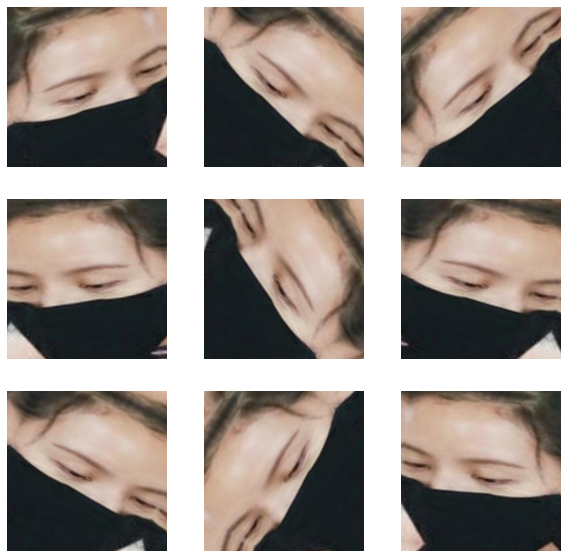

In [39]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [482]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

## Load Pre-trained MobileNetV2 

In [483]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [484]:
IMG_SHAPE

(224, 224, 3)

In [485]:
base_model.trainable = True

In [487]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [460]:
# base_model.layers

In [488]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


In [489]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [490]:
model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_24 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_24 (TFOpLam (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1280)              0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 1280)              0  

## Start training on fine tuned model architecture

In [491]:
initial_epochs = 20
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20
103/103 [==============================] - 16s 124ms/step - loss: 0.4907 - accuracy: 0.7302 - val_loss: 0.3714 - val_accuracy: 0.8962
Epoch 2/20
103/103 [==============================] - 12s 116ms/step - loss: 0.2312 - accuracy: 0.9141 - val_loss: 0.3039 - val_accuracy: 0.9121
Epoch 3/20
103/103 [==============================] - 12s 117ms/step - loss: 0.1509 - accuracy: 0.9487 - val_loss: 0.2456 - val_accuracy: 0.9280
Epoch 4/20
103/103 [==============================] - 12s 116ms/step - loss: 0.1142 - accuracy: 0.9600 - val_loss: 0.2007 - val_accuracy: 0.9377
Epoch 5/20
103/103 [==============================] - 12s 116ms/step - loss: 0.0856 - accuracy: 0.9713 - val_loss: 0.1621 - val_accuracy: 0.9512
Epoch 6/20
103/103 [==============================] - 12s 116ms/step - loss: 0.0711 - accuracy: 0.9777 - val_loss: 0.1219 - val_accuracy: 0.9683
Epoch 7/20
103/103 [==============================] - 12s 117ms/step - loss: 0.0652 - accuracy: 0.9771 - val_loss: 0.1055 - val_ac

## Plot training and validation history

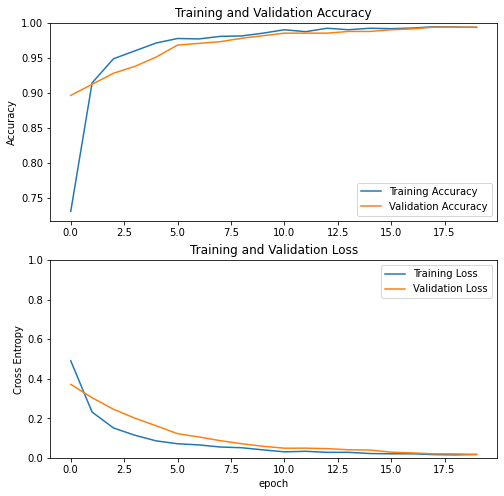

In [492]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Test Set Accuracy

In [513]:
loss1, accuracy1 = model.evaluate(test_dataset)
print('Test accuracy :', accuracy1*100, '%')

13/13 [==============================] - 1s 62ms/step - loss: 0.0181 - accuracy: 0.9951
Test accuracy : 99.5121955871582 %


## Make Prediction and Visualize images

[ 10.903972   -5.581962   12.474632   10.937747    6.8568487   9.407647
  -5.4756985  -9.888123   -3.1597779  -9.427746  -10.248149   13.321584
 -10.434901   -4.5785675 -10.034215   -6.737586   10.501702   -2.392954
  10.820192   13.7544775 -11.931199    9.954857   -6.7046666  12.063931
  13.951531   -9.452126    5.617402   10.62809    -7.2100935  -9.537231
  -9.14792    -6.3270736]
Predictions:
 [1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 1 0 0 0 0]
Labels:
 tf.Tensor([1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 1 0 0 0 0], shape=(32,), dtype=int32)


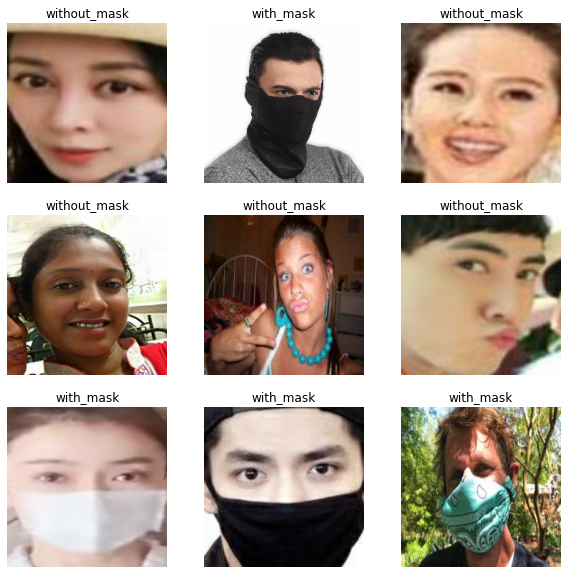

In [23]:
# Retrieve a batch of images from the test set
image_batch, label_batch = next(iter(test_dataset))
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
sigmoid = tf.nn.sigmoid(predictions)
print(predictions)
predict = tf.where(sigmoid < 0.5, 0, 1)

print('Predictions:\n', predict.numpy())
print('Labels:\n', label_batch)

class_names = ["with_mask", "without_mask"]

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i]/255)   #plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predict[i]])
  plt.axis("off")

In [502]:
model.save("mask_detect.h5")

In [515]:
model.save('mask_detect_model')

INFO:tensorflow:Assets written to: saved_model\assets


E:\Jupyter_Notebook_Projects\All_Projects\Experiments\DL\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## Combining in Single function

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

In [2]:
model = tf.keras.models.load_model("mask_detect.h5")

In [3]:
class_names = ["With Mask", "No Mask"]
def detect(image_array):
    #img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    img = np.around(np.array(image_array), decimals=12)
    img = np.expand_dims(img, axis=0)
    
    pred = model.predict_on_batch(img).flatten()
    sigmoid = tf.nn.sigmoid(pred)
    #print(pred)
    predict = tf.where(sigmoid < 0.5, 0, 1)
    predict = tf.cast(predict, tf.float32)
    prob = tf.math.add(tf.math.multiply((1-predict), (1-sigmoid)) , tf.math.multiply(predict, sigmoid))
    return(int(predict), round(float(prob)*100,2), class_names[int(predict[0])])
    
    

# Apply on Live Feed by OpenCV

Now we will apply the above trained model on live webcam feed.

## Measuring Illumination Condition of face before feeding into Neural Network

In [5]:
def illumination(image_array, bright_threshold = 0.5, dark_threshold = 0.5):
    bright_thres = bright_threshold
    dark_thres = dark_threshold
    frame = image_array
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    dark_part = cv2.inRange(gray, 0, 30)
    bright_part = cv2.inRange(gray, 220, 255)
    # use histogram
    # dark_pixel = np.sum(hist[:30])
    # bright_pixel = np.sum(hist[220:256])
    total_pixel = np.size(gray)
    dark_pixel = np.sum(dark_part > 0)
    bright_pixel = np.sum(bright_part > 0)
    
    if dark_pixel/total_pixel > bright_thres:
        print("Face is underexposed!")
        permission = False
        score = dark_pixel/total_pixel
        comment= "Illumination: Underexposed; Low Contrast or Brightness"
        return permission, score, comment
    
    if bright_pixel/total_pixel > dark_thres:
        print("Face is overexposed!")
        permission = False
        score = bright_pixel/total_pixel
        comment= "Illumination: Overexposed; High Contrast or Brightness"
        return permission, score, comment
    
    else:
        print('Normal Illumination!')
        permission = True
        score = None
        comment= "Illumination: Normal"
        return permission, score, comment

## Webcam live feed Test

In [4]:
import cv2, time

In [ ]:
import cv2, time
height = 1080
resolution = (height, round(height*(3/4)))

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)

#fourcc = cv2.VideoWriter_fourcc(*'MJPG')
#out = cv2.VideoWriter('output1.avi', fourcc, 20.0, (640, 480))

# used to record the time when we processed last frame
prev_frame_time = 0

# used to record the time at which we processed current frame
new_frame_time = 0


while cap.isOpened():
    rate, image = cap.read()
    orig_height = image.shape[1]
    #print(orig_height)
    
    image = cv2.resize(image, resolution, interpolation = cv2.INTER_AREA)
    #print(image.shape)
    #image = np.copy(img)
    if rate:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        #cv2.rectangle(image, (20, 20), (20 + 150, 20 + 150), (255, 0, 0), 2)
        
        x0, y0 =30, 40; w0, h0 = 250, 120
        cv2.rectangle(image, (x0,y0), (x0+w0,y0+h0), (255,255,255), 1)
        
        white_bg = np.ones((h0-10, w0, 3),dtype=np.uint8)*255
        image[y0+5:y0+h0-5, x0:x0+w0] = cv2.addWeighted(image[y0+5:y0+h0-5, x0:x0+w0], 0.3, white_bg, 0.7, 0.0)
                
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        
        verify = None
        
        for (x,y,w,h) in faces:
            print(str(w) + " , " + str(h))
            box_dim = (150/orig_height)*resolution[0]
            if (w >= box_dim) | (h >= box_dim):
                
                roi = image[y:y+h,x:x+w] # Face Region
                roi_new = cv2.resize(roi, (224, 224), interpolation = cv2.INTER_AREA) # Resize to same as input dimension of 
                                                                                      # Neural Network

                permission, score, comment = illumination(roi_new, 0.5, 0.2) # Check Illumination Before Passing into Network
                
                if permission: # Illumination conditon appropriate
                    
                    verify, prob, label = detect(roi_new)
                    
                    
                    if verify == 1: # Mask Detected
                        # Face Bounding Box
                        cv2.rectangle(image, (x,y), (x+w,y+h), (0, 0, 255), 1) # Face Bounding Box (Red Colour)
                        
                        cv2.rectangle(image, (x,y-50), (x+w,y), (0, 0, 255), -1) # Red ribbon over face bounding box

                        cv2.putText(image, "No Mask ("+str(prob)+"%)", (x+5, y-20), fontFace= cv2.FONT_HERSHEY_COMPLEX,
                                    fontScale= 0.7, color=(255, 255, 255), thickness=1, lineType= cv2.LINE_AA)
                        
                        
                    if verify == 0: # No Mask Detected
                        
                        cv2.rectangle(image, (x,y), (x+w,y+h), (0, 182, 0), 1) # Face Bounding Box (Green Colour)
                                                
                        cv2.rectangle(image, (x,y-50), (x+w,y), (0, 182, 0), -1) # Green ribbon over face bounding box

                        cv2.putText(image, "With Mask ("+str(prob)+"%)", (x+5, y-20), fontFace= cv2.FONT_HERSHEY_COMPLEX,
                                    fontScale= 0.7, color=(255, 255, 255), thickness=1, lineType= cv2.LINE_AA)
                        
                                        
                    # Writing Summary at top left    
                    cv2.putText(image, "Detected: ", (x0+5, y0 + round(h0/4)+5), fontFace = cv2.FONT_HERSHEY_COMPLEX,
                                fontScale= 0.7, color=(0, 0, 0), thickness=1, lineType = cv2.LINE_AA)
                    cv2.putText(image, label, (x0+120, y0 + round(h0/4)+5), fontFace = cv2.FONT_HERSHEY_COMPLEX,
                                fontScale= 0.7, color=(30*(1-verify), 150*(1-verify), 255*verify), thickness=1, lineType = cv2.LINE_AA)
                    cv2.putText(image, "Accuracy: "+str(prob)+"%", (x0+5, y0 + round((2*h0)/4)+5), fontFace = cv2.FONT_HERSHEY_COMPLEX,
                                fontScale= 0.7, color=(255, 0, 0), thickness=1, lineType = cv2.LINE_AA)
                    
                else: # Illumination conditon not appropriate
                    cv2.putText(image, comment, (10, 20), fontFace= cv2.FONT_HERSHEY_SIMPLEX,fontScale= 0.7,
                                color=(50, 50, 255), thickness=1, lineType= cv2.LINE_AA)
            
            else: # Face Detected but far from camera
                cv2.putText(image, "Please come close to camera", (10, 20), fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale= 0.7,
                    color=(50, 50, 255), thickness=1, lineType= cv2.LINE_AA)
        
        if verify is None:
            cv2.putText(image, "Detected: ", (x0+5, y0 + round(h0/4)+5), fontFace = cv2.FONT_HERSHEY_COMPLEX,
                        fontScale= 0.7, color=(0, 0, 0), thickness=1, lineType = cv2.LINE_AA)
            cv2.putText(image, "None", (x0+120, y0 + round(h0/4)+5), fontFace = cv2.FONT_HERSHEY_COMPLEX,
                        fontScale= 0.7, color=(0, 0, 255), thickness=1, lineType = cv2.LINE_AA)
            cv2.putText(image, "Accuracy: None", (x0+5, y0 + round((2*h0)/4)+5), fontFace = cv2.FONT_HERSHEY_COMPLEX,
                        fontScale= 0.7, color=(255, 0, 0), thickness=1, lineType = cv2.LINE_AA)



        new_frame_time = time.time()

        # Calculating the fps

        # fps will be number of frame processed in given time frame
        # since their will be most of time error of 0.001 second
        # we will be subtracting it to get more accurate result
        fps = 1 / (new_frame_time - prev_frame_time)
        prev_frame_time = new_frame_time

        # converting the fps into integer
        fps = int(fps)

        # converting the fps to string so that we can display it on frame
        # by using putText function
        fps = str(fps)
        height, width, _ = image.shape
        # putting the FPS count on the frame
        cv2.putText(image, "FPS: " + fps, (x0+5, y0 + round((3*h0)/4)+5), fontFace = cv2.FONT_HERSHEY_COMPLEX,
                    fontScale= 0.7, color=(113, 0, 166), thickness=1, lineType = cv2.LINE_AA)
        
        
        #out.write(image)
        
        cv2.imshow('Face Mask Detector', image)
        

        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    else:
        break

cap.release()

#out.release()
cv2.destroyAllWindows()